# Customer Lifetime Value (CLV) 

**Authors :**
* Louiza AOUAOUCHE
* Salim ABDOU DAOURA

**DESCRIPTION:**

The project consists in studying basic estimators so as to predict the potential duration that a customer could live in a company before churning. We define it as its lifetime value. For that, we use two type of data :
* Not censored data : means that at the moment of the measure, all the durations are known
* Censored data (more realistic): means that, for some customers, the duration is unknown since they are still in the company. (Their lifetimes will be equal to their seniority values in the company - ancienneté in french)

We use estimators based on three distributions because of their similarity with the survival function:
* **Geometric distribution**
* **Exponential distribution**
* **Pareto distribution**

In [634]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [635]:
#GLOBAL CONSTANTS
clv_thoery = 10 
size= 10000 # size of each sample
n = 10000 # number of samples
DureeObs = 12*2 # duration of observation

# PACKAGE

The package contains a group of functions that are useful to generate data, compute confidence intervals or boostrapping.

**Generators**

In [ ]:
# EXPONENTIAL GENERATOR - without censored data 
def generate_exponential_perfect(mean, size):
    """
    Generates random numbers following an exponential distribution

    Args:
        mean (float): The mean of the distribution.
        size (int): The number of random numbers to generate.

    Returns:
        An array of random numbers following an exponential distribution
        with the given mean.
    """
    return np.random.exponential(scale=mean, size=size)

In [637]:
def generate_exponential(mean, size , obs_duration):
    """
    Generates random numbers following an exponential distribution with some censored data

    Args:
        mean (float): The mean of the distribution.
        size (int): The number of random numbers to generate.
        obs_duration (int) : Duration of observation

    Returns:
        An array of random numbers following an exponential distribution
        with the given mean.
    """
    T = np.random.exponential(scale=mean, size=size)
    ancient = obs_duration * np.random.rand(size) # uniform distribution
    Y = T*(T<=ancient) +  ancient*(T>ancient)
    return Y , ancient

**Confidence interval**

In [638]:
def confidence_lvl(lower_bound, upper_bound, estimators):
    """
    Calculates the percentage of estimates falling within a given confidence interval.

    Parameters:
    lower_bound (float): The lower limit of the confidence interval.
    upper_bound (float): The upper limit of the confidence interval.
    estimators (list[float]): A list of estimates.

    Returns:
    float: The percentage of estimates falling within the confidence interval.
    """
    in_IC=0
    for x in estimators : 
        if (x<upper_bound and x>lower_bound) : in_IC +=1
    return (in_IC / len(estimators))*100

In [639]:
def CI_plot(clv_values, lower, upper):
    """
    Plots confidence intervals 
    
    Args:
        clv_values : clv values related to the confidence intervals
        lower : The lower limit of the confidence interval.
        upper : The upper limit of the confidence interval.
    """
    
    # Define x-axis values
    x = range(len(clv_values))

    # Set figure size
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot the data
    ax.plot(x, clv_values, label='Computed Value', color='blue')
    #ax.plot(x, lower, color='red', label='lower')
    #ax.plot(x, upper, color='green', label='upper')
    ax.fill_between(x, lower, upper, alpha=0.2, label='95% CI', color='gray')

    # Add labels and legend
    ax.set_xlabel('Sample')
    ax.set_ylabel('CLV')
    ax.set_title('CLV Computation Results')
    ax.legend(loc='best')

    # Show the plot
    plt.show()

In [640]:
def CI_multiplot(clv, lower , upper):
    """
    Plots confidence intervals
    Plots lower, upper distributions
    Prints confidence level
    
    Args:
        clv_values : clv values related to the confidence intervals
        lower : The lower limit of the confidence interval.
        upper : The upper limit of the confidence interval.
    """
    
    # plot confidence interval
    CI_plot(clv, lower, upper)

    # plot of the distribution
    sns.histplot(lower, color='blue', kde=True, label='Lower CI')
    sns.histplot(upper, color='orange', kde=True, label='Upper CI')
    
    # Add titles and axis labels
    plt.title('Distribution of IC')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Add legend to the plot
    plt.legend()

    # Show the plot
    plt.show()
    
    
    # print confidence level
    print(f"CONFIDENCE LEVEL: {confidence_lvl(np.mean(lower), np.mean(upper), clv):.2f}%")

**Boostrap**

In [641]:
def bootstrap(data1, data2): #
    """
    Performs bootstrap resampling on two datasets by randomly selecting data points with replacement.

    Parameters:
    data1 (list): The first dataset to be resampled.
    data2 (list): The second dataset to be resampled.

    Returns:
    tuple: A tuple of two lists, containing the resampled data from each dataset.
    """
    # Initialize two empty lists to hold the resampled data
    sample1 = []
    sample2 = []

    # Loop through each data point in the datasets
    for i in range(len(data1)):
        # Generate a random integer between 0 and the length of the dataset - 1
        rand_int = random.randint(0, len(data1) - 1)
        # Add the randomly selected data points to the resampled datasets
        sample1.append(data1[rand_int])
        sample2.append(data2[rand_int])

    # Return the resampled datasets as a tuple
    return sample1, sample2

In [644]:
def bootstrap_confidence_interval(data, censored, func, alpha=0.05, B=100):
    """
    Computes confidence interval based on bootstrapping
    
    Args:
        data : data points (lifetime of customers) for one sample
        censored ({0,1}) : 0 if data is not censored, 1 if it is 
        func : function calculating the CLV value according to data distribution
        alpha (0<= float <=1): significance level
        B : number of boostrap samples
    
    Returns:
    (float,float): the lower and upper bound of the confidence interval
    
    """
    n = len(data[0]) if censored else len(data)# Get the length of the original data
    
    bootstrap_statistics = []  # Initialize an empty list to store bootstrap statistics

    # Generate B bootstrap samples and compute the statistic of interest for each sample
    for b in range(B):
        random_indices = np.random.choice(range(n), size=n, replace=True)
        if censored:
            Y_bootstrap_sample = data[0][random_indices]  # Randomly sample n values with replacement
            A_bootstrap_sample = data[1][random_indices]
            bootstrap_statistic = func(Y_bootstrap_sample,A_bootstrap_sample)  
        else :
            bootstrap_sample = data[random_indices]  # Randomly sample n values with replacement
            bootstrap_statistic = func(bootstrap_sample)  # Compute the mean (replace with your desired statistic)
        bootstrap_statistics.append(bootstrap_statistic)  # Store the computed statistic for the bootstrap sample

    bootstrap_statistics.sort()  # Sort the bootstrap statistics in ascending order
    lower_percentile = 100 * alpha / 2  # Calculate the lower percentile of the confidence interval
    upper_percentile = 100 * (1 - alpha / 2)  # Calculate the upper percentile of the confidence interval
    lower_bound = np.percentile(bootstrap_statistics, lower_percentile)  # Calculate the lower bound of the confidence interval
    upper_bound = np.percentile(bootstrap_statistics, upper_percentile)  # Calculate the upper bound of the confidence interval

    return lower_bound, upper_bound  # Return the lower and upper bounds of the confidence interval


In [645]:
def bootstrap_intervals(list_data, censored, func,  alpha=0.05, B=100):
    """
    Computes confidence interval based on bootstrapping
    
    Args:
        list_data : data points (lifetime of customers) for a list of samples
        censored ({0,1}) : 0 if data is not censored, 1 if it is 
        func : function calculating the CLV value according to data distribution
        alpha (0<= float <=1): significance level
        B : number of boostrap samples
    
    Returns:
    (float,float): the lower and upper bound of the confidence interval
    
    ================================================================================================================
    WARNING : the size of the data and value of B can affect drasticly the complexity of this function
    ================================================================================================================
    """
    
    
    lower_bounds = []
    upper_bounds = []
    
    for data in list_data:
        lower_bound,upper_bound = bootstrap_confidence_interval(data, censored, func, alpha, B)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
    return lower_bounds,upper_bounds

##### clv functions

In [673]:
def print_conv_plot_distribution(size, n ,clv_theory, clv_real):
    """
    Plots the distribution of the errors of estimation between clv_thoery and clv_real
    Prints values about clv_real (mean, standard deviation)    
    """
    
    # clv_avg = clv_hat that averages all the estimated values of clv
    clv_avg = np.mean(clv_real)
    
    # standard deviation of clv
    clv_std = np.std(clv_real)
    
    # difference between clv predicted and the actual value
    clv_errors = np.array(clv_real) - clv_theory
    
    # print convergence values
    print("CONVERGENCE :\n \t size of each dataset =%d \n \t number of datasets =%d \n \t CLV thoery = %d \n \t CLV real = %f  \n \t Standard deviation CLV= %f" % (size, n,clv_theory,clv_avg,clv_std))
    
    # plot distribution of errors
    sns.histplot(clv_errors, kde = True).set_title("Distribution of CLV errors for all samples")

In [677]:
def monte_carlo(clv_thoery, size, n, censored, clv_func, generator_fun ):
    """
    Computes the clv value according to the func argument
    Args:
        clv_thoery : data points (lifetime of customers) for a list of samples
        size : size of each sample
        n : number of samples to generate
        func : function calculating the CLV value according to data distribution (geomtric, exponential)
    Returns:
        clv : avergae of clv values of all samples
        Y_n : list of samples    
    """
    clv = [] # list containing average of clv values for all samples
    Y_n = [] # list containing all the generated data

    for i in range(n):
        
        if censored:
            # generating data 
            Y_new, ancient_new = generator_fun(clv_thoery, size,DureeObs )
            # storing the sample
            Y_n.append((Y_new, ancient_new))
            # computing the avergae clv value of the sample
            clv.append(clv_func(Y_new, ancient_new))
        else:
            # generating data 
            Y_i = generator_fun(clv_thoery, size) 
            # storing the sample
            Y_n.append(Y_i)
            # computing the avergae clv value of the sample
            clv.append(clv_func(Y_i))
    
    return clv, Y_n

Geomtric estimator - not censored

In [ ]:
def geom_clv_estimator(T):
    """
    Function to calculate the geometric clv estimator
    
    Parameters:
    T (list or array): list or array of numerical values
    
    Returns:
    float: the geometric clv estimator of the values in T
    """
    return np.sum(T)/len(T)

Geomtric estimator - censored

In [ ]:
def geom_c_clv_estimator(Y, ancient):
    """
    Function to calculate the geometric clv estimator
    
    Parameters:
    Y (array): numerical values related to known lifetimes
    ancient (array): seniority values of customers since they entered the company 
    
    Returns:
    float: the geometric clv estimator values
    """
    A = np.where(Y!=ancient)[0]  
    N = np.where(Y==ancient)[0]
    return (np.sum(Y[A]) + np.sum(ancient[N]))/len(A)

Exponential estimator - not censored

In [689]:
def exp_nc_clv_estimator(T):
    """
    Function to calculate the exponential clv estimator
    
    Parameters:
    T (list or array): list or array of numerical values
    
    Returns:
    float: the exponential clv estimator of the values in T
    """
    return np.sum(T)/len(T)

Exponential estimator - censored

In [ ]:
def exp_clv_estimator(Y , ancient):
    A = np.where(Y!=ancient)[0] # available data : T_i < a_i
    return np.sum(Y) /len(A)

In [ ]:
def CI_exp_c_clv(a,Y,ancient):
    len_A = len(np.where(Y!=ancient)[0])
    lower = np.sum(Y)/(len_A + a * np.sqrt(len_A))
    upper = np.sum(Y)/(len_A + - a * np.sqrt(len_A))
    
    return lower, upper

# Geometric estimator (not censored)

**CLV computing**

In [688]:
# CONSTANT desining if the data is going to be censored or not
censored = 0
# Monte Carlo simulation
clv_geom, Y_n = monte_carlo(clv_thoery, size, n, censored, geom_clv_estimator, generate_exponential_perfect)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10 
 	 CLV real = 9.999755  
 	 Standard deviation CLV= 0.099957


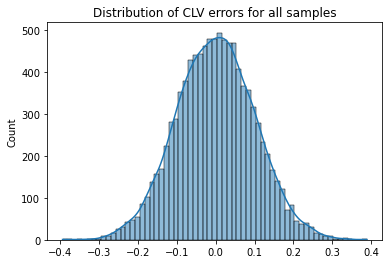

In [682]:
# plot clv errors distribution
print_conv_plot_distribution(size, n ,clv_thoery, clv_geom)

For all the samples $Y_i$ for $i\in \{1,...,n\}$ the prediction error $(prediction_i - expectation_i)$ folllows a gaussian distribution with mean 0.


**Confidence interval**

In [651]:
lower_geom_nc, upper_geom_nc =bootstrap_intervals(Y_n, censored , np.mean)

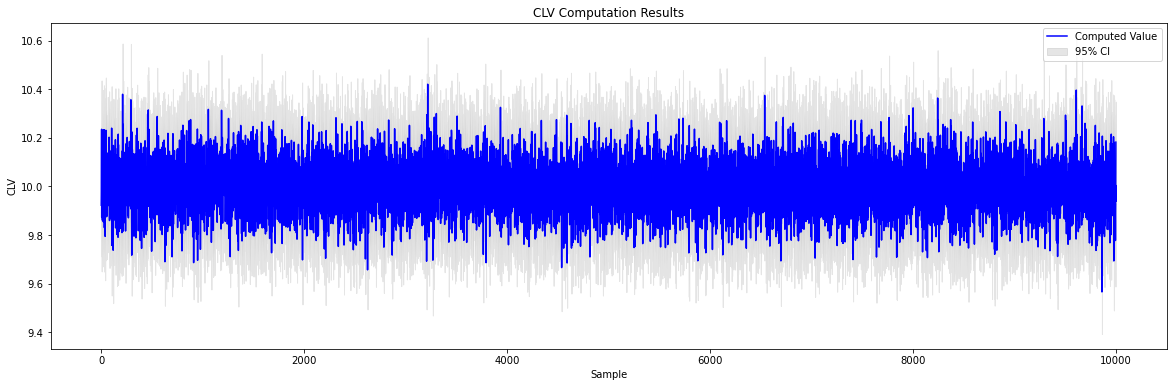

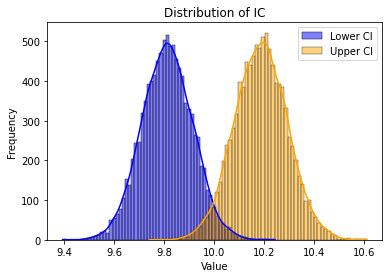

CONFIDENCE LEVEL: 94.02%


In [652]:
# plot confidence interval
CI_multiplot(clv_geom, lower_geom_nc, upper_geom_nc)

## Geometric (censored)

**CLV computing**

In [687]:
# CONSTANT
censored = 1
# Monte Carlo simulation
clv_geom_c, Y_n = monte_carlo(clv_thoery, size, n, censored, geom_c_clv_estimator, generate_exponential)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10 
 	 CLV real = 10.001186  
 	 Standard deviation CLV= 0.126991


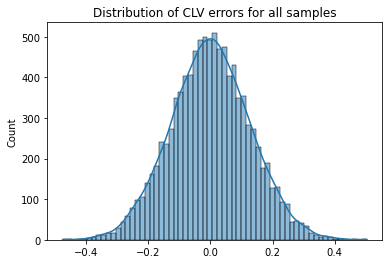

In [686]:
print_conv_plot_distribution(size, n ,clv_thoery, clv_geom_c)

**Confidence interval**

In [657]:
lower_geom_c, upper_geom_c =bootstrap_intervals(Y_n, censored,geom_c_clv_estimator )

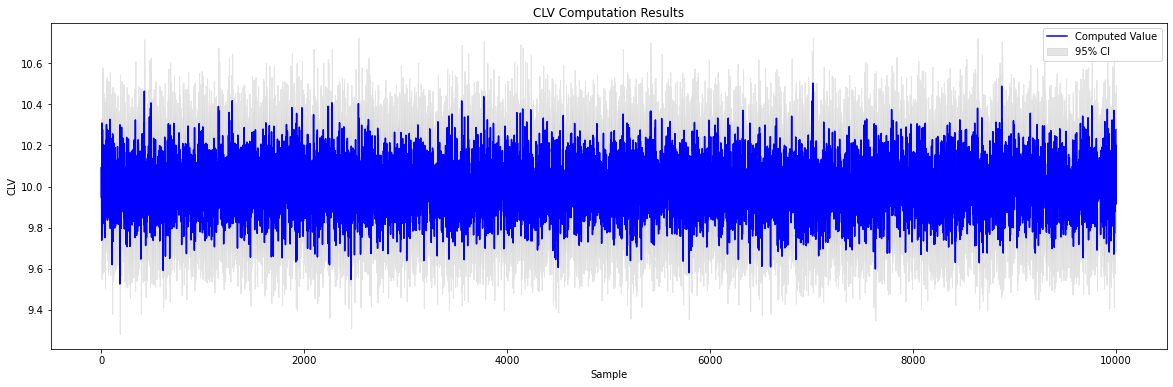

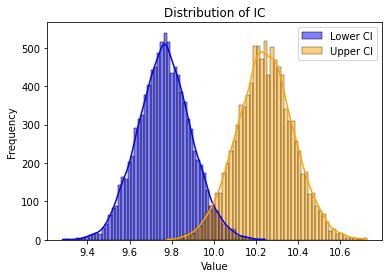

CONFIDENCE LEVEL: 93.81%


In [658]:
# plot confidence interval
CI_multiplot(clv_geom_c, lower_geom_c, upper_geom_c)

## Exponential (not censored)

**CLV computing**

In [661]:
# CONSTANT
censored = 0
# Monte Carlo simulation
clv_exp_nc, Y_n = monte_carlo(clv_thoery, size, n, censored, exp_nc_clv_estimator, generate_exponential_perfect)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10 
 	 CLV real = 10.000804  
 	 Standard deviation CLV= 0.100343


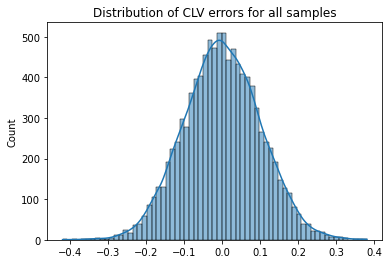

In [662]:
print_conv_plot_distribution(size, n ,clv_thoery, clv_exp_nc)

**confidence interval**

In [663]:
lower_exp_nc, upper_exp_nc =bootstrap_intervals(Y_n,censored,np.mean)

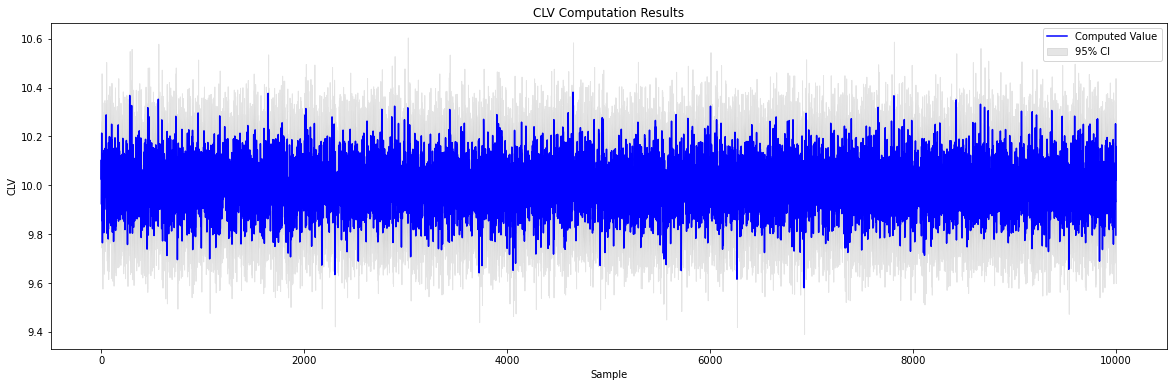

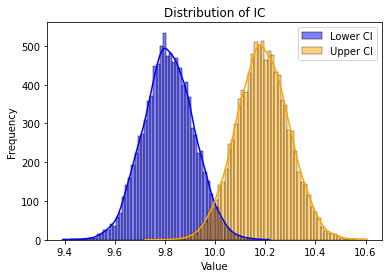

CONFIDENCE LEVEL: 94.13%


In [664]:
# plot confidence interval
CI_multiplot(clv_exp_nc, lower_exp_nc, upper_exp_nc)

## Exponential (censored)

**CLV computing**

In [668]:
# CONSTANT
censored = 1
# Monte Carlo simulation
clv_exp_nc, Y_n = monte_carlo(clv_thoery, size, n, censored, exp_clv_estimator, generate_exponential)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10 
 	 CLV real = 10.001428  
 	 Standard deviation CLV= 0.126088


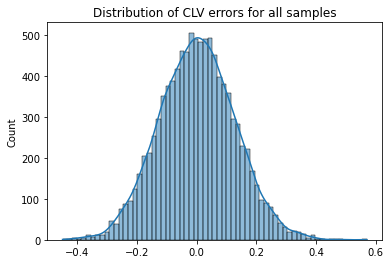

In [669]:
print_conv_plot_distribution(size, n ,clv_thoery, clv_exp_c)

The error is still normally distributed and the standart deviation is higher. 
(As censored data are normally distributed, they have no impact on the error distribution. Censored data increase the std of the error)

**Theoretical confidence intervals**

In [ ]:
lower_exp_c = []
upper_exp_c = []
for i in range(n):
    lower_exp_c.append(CI_exp_c_clv(1.96, Y_n[0][i], Y_n[1][i])[0])
    upper_exp_c.append(CI_exp_c_clv(1.96, Y_n[0][i], Y_n[1][i])[1])

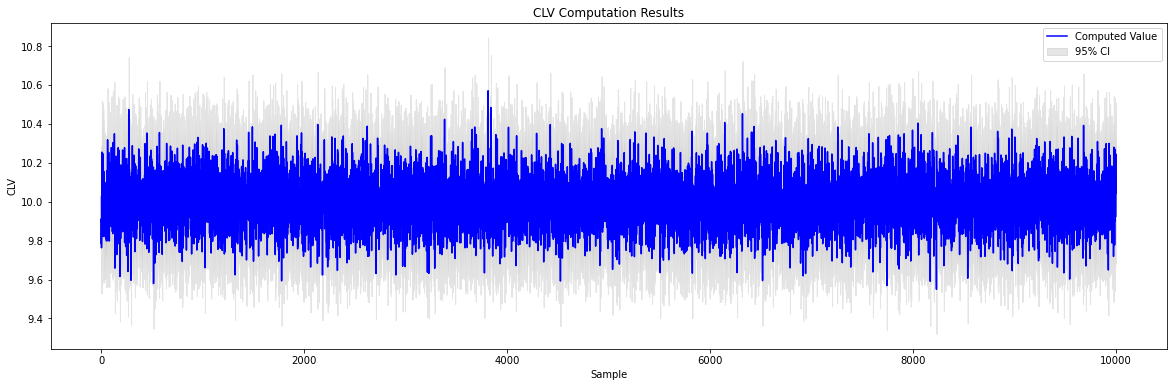

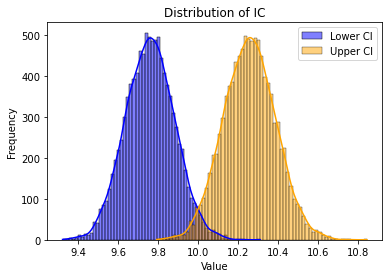

CONFIDENCE LEVEL: 95.14%


In [670]:
# plot confidence interval
CI_multiplot(clv_exp_c, lower_exp_c, upper_exp_c)

**Bootstrap confidence intervals**

In [671]:
lower_exp_c2, upper_exp_c2 =bootstrap_intervals(Y_n,censored,exp_clv_estimator)

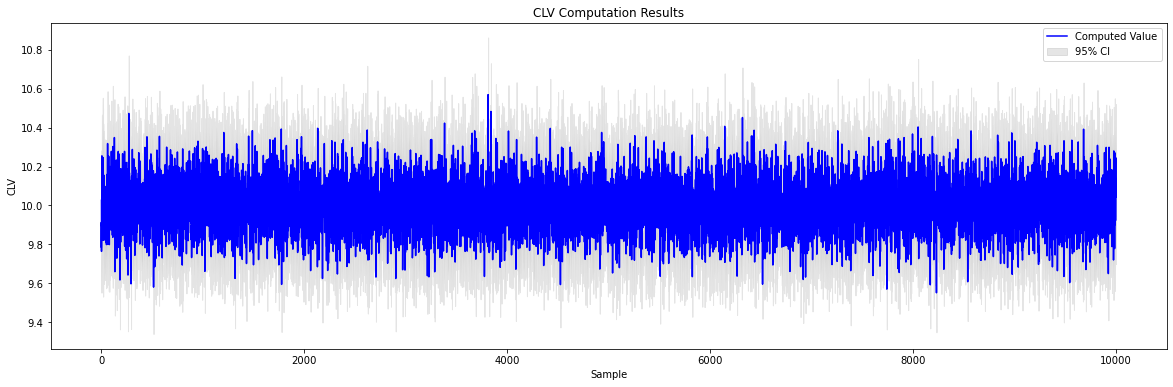

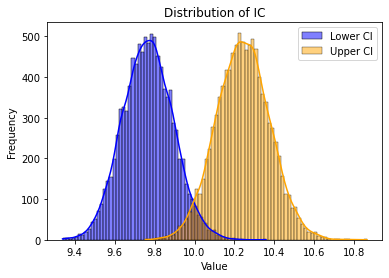

CONFIDENCE LEVEL: 94.07%


In [672]:
# plot confidence interval
CI_multiplot(clv_exp_c, lower_exp_c2, upper_exp_c2)

# HAAAALTE ! DOIIIIIIIIIIIIIIIIIIIIIIIINE

##### PARETO 

In [ ]:
def generate_pareto(scale, size,obs_duration,shape  ):
    T = np.random.pareto(a=shape, size=size) * scale  # shape parameter (a) set to 1.5
    ancient = obs_duration* np.random.rand(size)  # uniform distribution
    Y = T * (T <= ancient) + ancient * (T > ancient)
    return Y, ancient

In [ ]:
scale = 1
size= 1000
DureeObs = 12*2
shape = 1.5

mean = (shape * scale) /(shape - 1 )

Y ,ancient = generate_pareto(scale, size, DureeObs, shape)
sns.histplot(Y, kde = True)

In [ ]:
len(np.where(Y!=ancient)[0])

In [ ]:
mean

In [ ]:
def pareto_clv_estimator(Y, ancient):
    len_A = len(np.where(Y!=ancient)[0])
    denom = 1- (np.sum(np.log(Y))/len_A)
    return 1 / denom

In [ ]:
clv_pareto = pareto_clv_estimator(Y,ancient)
epsilon = 0.1
n = 1000
max_size = 10000
while (np.abs(clv_pareto-mean)>epsilon and (n <= max_size)) :
    n +=1
    Y_new, ancient_new = generate_pareto(mean, n, DureeObs,shape)
    clv_pareto = pareto_clv_estimator(Y_new, ancient_new)


In [ ]:
print("CONVERGENCE WITH DIFFERENCE OF ε = %.3f :\n \t size of dataset =%d \n \t CLV real = %f \n \t CLV thoery = %d" % (epsilon, n ,clv_pareto,mean))

In [ ]:
# GENERATOR WITH TWO PARETO DISTRIBUTION
# Parameters
n = 1000
DureeObs = 12*4

moyenne1 = 4  # Mean in the first group
shape1 = 0.1  # Small shape: close to exponential distribution

moyenne2 = 9  # Mean in the second group
shape2 = 0.4  # Larger shape: heavy-tailed distribution

ratio_classe = 0.3  # Proportion of clients in the first group in the dataset

# Expectation across both groups
CLV = ratio_classe*moyenne1+(1-ratio_classe)*moyenne2

# Data generation
location1 = 0
scale = moyenne1*(1-shape1)-location1
T1 = np.random.gamma(shape1, scale, n)

location2 = 0
scale = moyenne2*(1-shape2)-location2
T2 = np.random.gamma(shape2, scale, n)

ber = np.random.rand(n) > ratio_classe

T = (1-ber)*T1 + ber*T2

Duree_depuis_souscription = DureeObs * np.random.rand(n)
Y = T*(T<Duree_depuis_souscription)
#Y = np.where(T<Duree_depuis_souscription, T, np.nan)


# The data is now (Y, Duree_depuis_souscription)

In [ ]:
# GENERATOR WITH ONLY ONE PARETO DISTRIBUTION

# Parameters
n = 1000
DureeObs = 12*4

moyenne1 = 4  # Mean in the first group
shape1 = 0.1  # Small shape: close to exponential distribution

#moyenne2 = 9  # Mean in the second group
#shape2 = 0.4  # Larger shape: heavy-tailed distribution

#ratio_classe = 0.3  # Proportion of clients in the first group in the dataset

# Expectation across both groups
CLV = moyenne1 #+(1-ratio_classe)*moyenne2

# Data generation
location1 = 0   # Que fait location et que fait shape
scale = moyenne1*(1-shape1)-location1
T = np.random.gamma(shape1, scale, n)


# location2 = 0
# scale = moyenne2*(1-shape2)-location2
# T2 = np.random.gamma(shape2, scale, n)

# ber = np.random.rand(n) > ratio_classe  

# T = (1-ber)*T1 + ber*T2

Duree_depuis_souscription = DureeObs * np.random.rand(n) # Q
Y = T*(T<=Duree_depuis_souscription) +  Duree_depuis_souscription*(T>Duree_depuis_souscription)
#Y = np.where(T<Duree_depuis_souscription, T, np.nan)

# The data is now (Y, Duree_depuis_souscription)

In [ ]:
df = pd.DataFrame({'Y': Y, 'DUREE_SOUSCRIPTION':Duree_depuis_souscription}, columns=['Y', 'DUREE_SOUSCRIPTION'])

In [ ]:
df.describe()

In [ ]:
# null values
df.isnull().sum()

In [ ]:
sns.histplot(Y, bins=10, kde = True)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Distribution of Y')
plt.show()

#### Parametric estimator

In [ ]:
# Define the estimator function
def CLV_pareto_IC(Y, DS):
    D = len(Y[Y<Duree_depuis_souscription])
    denom = 1- (np.sum(np.log(Y))/D)
    return 1 / denom

In [ ]:
print("CLV HAT :",clv_pareto(Y,Duree_depuis_souscription))
print("CLV :", CLV)

In [ ]:
print("CLV HAT :",clv_geom(Y,Duree_depuis_souscription))
print("CLV :", CLV)

##### Confidence interval

In [ ]:
# Perform bootstrap sampling to estimate confidence interval
B = 200  # Number of bootstrap samples
bootstrap_samples = np.random.choice(n, size=(B, n), replace=True)
bootstrap_estimators = np.zeros(B)
for b in range(B):
    Y_b = Y[bootstrap_samples[b]]
    DS_b = Duree_depuis_souscription[bootstrap_samples[b]]
    bootstrap_estimators[b] = clv_hat(Y_b, DS_b)

# Compute confidence interval
alpha = 0.05  # Significance level
lower = np.percentile(bootstrap_estimators, 100*(alpha/2))
upper = np.percentile(bootstrap_estimators, 100*(1-alpha/2))

print("CLV hat: ", clv_hat(Y, Duree_depuis_souscription))
print("95% confidence interval: [", lower, ",", upper, "]")

In [ ]:
print("VAR(CLV hat): ", bootstrap_estimators.std()**2)

In [ ]:
import seaborn as sns

# Plot the bar chart
sns.histplot(bootstrap_estimators, bins=30, kde=True)

# Show the plot
plt.show()



#### Geometric with Nan data

In [ ]:
# Define the estimator function
#
def clv_geom(Y, DS):
    np.where(~np.isnan(Y))[0]  
    N = np.where(np.isnan(Y))[0]
    return (np.sum(Y[A]) + np.sum(DS[N]))/len(A)

In [ ]:
# Parameters
n = 1000
DureeObs = 12*4

moyenne1 = 4  # Mean in the first group
p1 = 0.2  # Probability of success in each trial, for a geometric distribution

moyenne2 = 9  # Mean in the second group
p2 = 0.6  # Probability of success in each trial, for a geometric distribution

ratio_classe = 0.3  # Proportion of clients in the first group in the dataset

# Expectation across both groups
CLV = ratio_classe*moyenne1+(1-ratio_classe)*moyenne2

# Data generation
T1 = np.random.geometric(p1, n)/p1 - 1  # Subtract 1 to shift distribution
T1 = T1 * moyenne1/np.mean(T1)  # Rescale to match mean

T2 = np.random.geometric(p2, n)/p2 - 1  # Subtract 1 to shift distribution
T2 = T2 * moyenne2/np.mean(T2)  # Rescale to match mean

ber = np.random.rand(n) > ratio_classe

T = (1-ber)*T1 + ber*T2

Duree_depuis_souscription = DureeObs * np.random.rand(n)
Y = T*(T<Duree_depuis_souscription)
#Y = np.where(T<Duree_depuis_souscription, T, np.nan)

# The data is now (Y, Duree_depuis_souscription)


In [ ]:
df2 = pd.DataFrame({'Y': Y, 'DUREE_SOUSCRIPTION':Duree_depuis_souscription}, columns=['Y', 'DUREE_SOUSCRIPTION'])

In [ ]:
df2.describe()

In [ ]:
print("CLV HAT :",clv_hat(Y,Duree_depuis_souscription))
print("CLV :", CLV)

In [ ]:
# Perform bootstrap sampling to estimate confidence interval
B = 200  # Number of bootstrap samples
bootstrap_samples = np.random.choice(n, size=(B, n), replace=True)
bootstrap_estimators = np.zeros(B)
for b in range(B):
    Y_b = Y[bootstrap_samples[b]]
    DS_b = Duree_depuis_souscription[bootstrap_samples[b]]
    bootstrap_estimators[b] = clv_hat(Y_b, DS_b)

# Compute confidence interval
alpha = 0.05  # Significance level
lower = np.percentile(bootstrap_estimators, 100*(alpha/2))
upper = np.percentile(bootstrap_estimators, 100*(1-alpha/2))

print("CLV hat: ", clv_hat(Y, Duree_depuis_souscription))
print("95% confidence interval: [", lower, ",", upper, "]")

In [ ]:
# Plot the bar chart
sns.histplot(bootstrap_estimators, bins=30, kde=True)

# Show the plot
plt.show()


### Quick trial of scikit learn survival analysis package

[Survival analysis](https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#What-is-Survival-Analysis?)

In [ ]:
!pip install scikit-survival  

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sksurv.datasets import load_aids

In [ ]:
# read the dataset
# ex other type of data : bank information source kaggle : https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?resource=download

"""
AIDS Clinical Trial dataset
The dataset has 1,151 samples and 11 features. The dataset has 2 endpoints:
.AIDS defining event, which occurred for 96 patients (8.3%)
.Death, which occurred for 26 patients (2.3%)
"""

# data_x : The measurements for each patient.
data_x, data_y = load_aids()

In [ ]:
data_x.head(3)

e.tdm: boolean indicating whether the endpoint has been reached or the event time is right censored.

t.tdm: time to distant metastasis (days)

In [ ]:
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

In [ ]:
%matplotlib inline
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["censor"], data_y["time"])
plt.step(time, survival_prob, where="post")
plt.ylabel("probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [ ]:
survival_times = np.array([5, 3, 2, 4, 7, 6, 5, 1, 8, 4, 3, 5, 6])
event_indicators = np.array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])
event_indicators_bool = [x==1 for x in event_indicators]

In [ ]:
t , s = kaplan_meier_estimator(event_indicators_bool, survival_times )
plt.plot(t, s)
plt.ylabel("probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Survival function properties:
$$\hat S(t) = \prod_{t_i \leq t} \frac{n_i - d_i}{n_i} = \prod_{t_i \leq t} 1 - \frac{d_i}{n_i} =\prod_{t_i \leq t} 1 - \frac{\text{number of events that happened at time }t_i }{\text{number of individuals known to have survived up to time }t_i } = \prod_{t_i \leq t} p_{t_i} $$

Another form:
$$\hat S(t) = \hat S(t-1)p_t$$


In [ ]:
def kaplan_meier_estm(event_indicators , survival_times ):
    """
    Fits the Kaplan-Meier survival curve to the input event indicators and survival times.

    Parameters:
    survival_times (np array): time from study inclusion to event (death, relapse, etc.)
    event_indicators (binary np array): the event of interest that occurs during the follow-up time (e.g., mortality, relapse, etc.)

    Returns:
    s (np array): estimated survival probabilities at each time point
    t (np array): unique times at which the estimated survival probabilities change.
    """

    # length of dataset
    n = len(survival_times)

    # compute unique survival times
    t = np.unique(survival_times)
    m = len(t)

    # array that store the survival probabilities
    s = np.ones(m)

    # array that store the number of events
    d = np.zeros(m)

    for i in range(m):
        # Count the number of events that occur (event indicator = 1) at time i
        d[i] = np.sum((survival_times == t[i]) & event_indicators)

        # compute the survival probability at time i
        n_i = n - sum(d[:i]) # - d
        s[i] = s[max(0, i-1)] * (1 - d[i] / n_i)
    return t, s


In [ ]:
# Example usage

t_new, s_new = kaplan_meier_estm(event_indicators , survival_times)
print("Difference with KME of sklearn t:",t-t_new)
print("Difference with KME of sklearn s:",s-s_new)
plt.plot(t_new, s_new)
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Kaplan-Meier Survival Curve")
plt.show()

In [ ]:
#problem : difference of 0.2 on the probabilities ... choice of the formula? 
#next: fonction fit - selon un clustering ? predict - métriques? ??

### Dataset

Since there's not access to the real data, the first step to do is to find/construct a dataset where the CLV can measurable/predictable. One can need to have some features such as: 
* Personal information : occupation, salary, gender, age, marital status, Geolocalisation (Country/town ...etc)
* Date of entry to company/study
* Date of leaving (can be empty if the element didn't quit yet)
* Information related to the person as a client : number & types of products , communication email/call ...